In [1]:
import pandas as pd 
import numpy as np 
import os 
# to run the regression
import statsmodels.api as sm
# import statsmodels.stats.api as sms
# plot libraries used
from plotnine import *
from mizani.formatters import percent_format
#  check results are correct with minimizer
from scipy.optimize import minimize


## Load in data

In [2]:
df = pd.read_csv(r'../../data/data-exam-2024.csv')

## See data

# Regression model
$$r_{i,t} = \alpha_i + \beta_i^{M} r_{m,t} + \beta_i^{SMB}r_{SMB,t} + \beta_i^{HML} r_{HML,t} + \epsilon_{i,t}$$

### Question 1
Use the data until (including) December 31, 2015 to estimate the parameters of the Fama-French 3 factor model. 
Report the distribution of the estimated values $\hat{\alpha}_i$ and $\hat{\beta}_i^{k}$ for all stocks. Give a brief interpretation of the values

In [53]:
# slice dataframe to only have data from before 1st of January 2016
df_ff = df.loc[df['month']<='2015-12-31']

def ff_regression(data: pd.DataFrame,residuals:bool=True):
    """This function runs the regression of the ff model"""
    y_value = data['ret_excess']
    x_values = data[['mkt_excess','smb','hml']]
    res = sm.OLS(y_value, sm.add_constant(x_values)).fit()

    if residuals:
        return_values = res.resid
    else: 
        return_values = res.params
    return return_values
    # consider heteroscedacity

# run the regression 
ff_reg_coef_unstack = df_ff.groupby('permno').apply(ff_regression,residuals=False)
ff_reg_coef_unstack = ff_reg_coef_unstack.rename(columns={'const':'alpha','mkt_excess':'beta_rm','smb':'beta_smb','hml':'beta_hml'})

# join the variance of the residuals
residuals = df_ff.groupby('permno').apply(ff_regression,residuals=True)
var_res = residuals.reset_index().rename(columns={0:'residuals'}).groupby('permno')['residuals'].var().reset_index()
ff_reg_coef_unstack = ff_reg_coef_unstack.merge(var_res,left_index=True,right_on='permno',how='inner').set_index('permno')
ff_reg_coef_unstack

,alpha,beta_rm,beta_smb,beta_hml,residuals
permno,,,,,
10026,0.010171,0.561058,0.597261,0.443743,0.005144
10032,0.005192,1.756704,0.863147,-0.259299,0.014166
10044,0.014266,0.623677,0.108821,0.159633,0.012541
10107,0.003265,1.196996,-0.270320,-0.628490,0.004936
10200,0.028509,0.921766,2.101678,-2.065194,0.036567
...,...,...,...,...,...
43350,0.004372,1.119928,0.077657,0.720607,0.003487
43481,0.004215,0.734755,0.811283,1.181009,0.007120
47379,-0.006998,0.995476,0.937396,1.019079,0.005226


In [61]:
ff_reg_coef = (ff_reg_coef_unstack.stack()
    .reset_index()
    .rename(columns={'level_1':'coeff',0:'value'})
    )

In [58]:
coeffs = ['alpha','beta_rm','beta_smb','beta_hml']
for coeff in coeffs:
    print(f"Mean of {coeff} is {ff_reg_coef.loc[ff_reg_coef['coeff']==coeff,'value'].mean():.3f}")

Mean of alpha is 0.005
Mean of beta_rm is 0.917
Mean of beta_smb is 0.477
Mean of beta_hml is 0.486


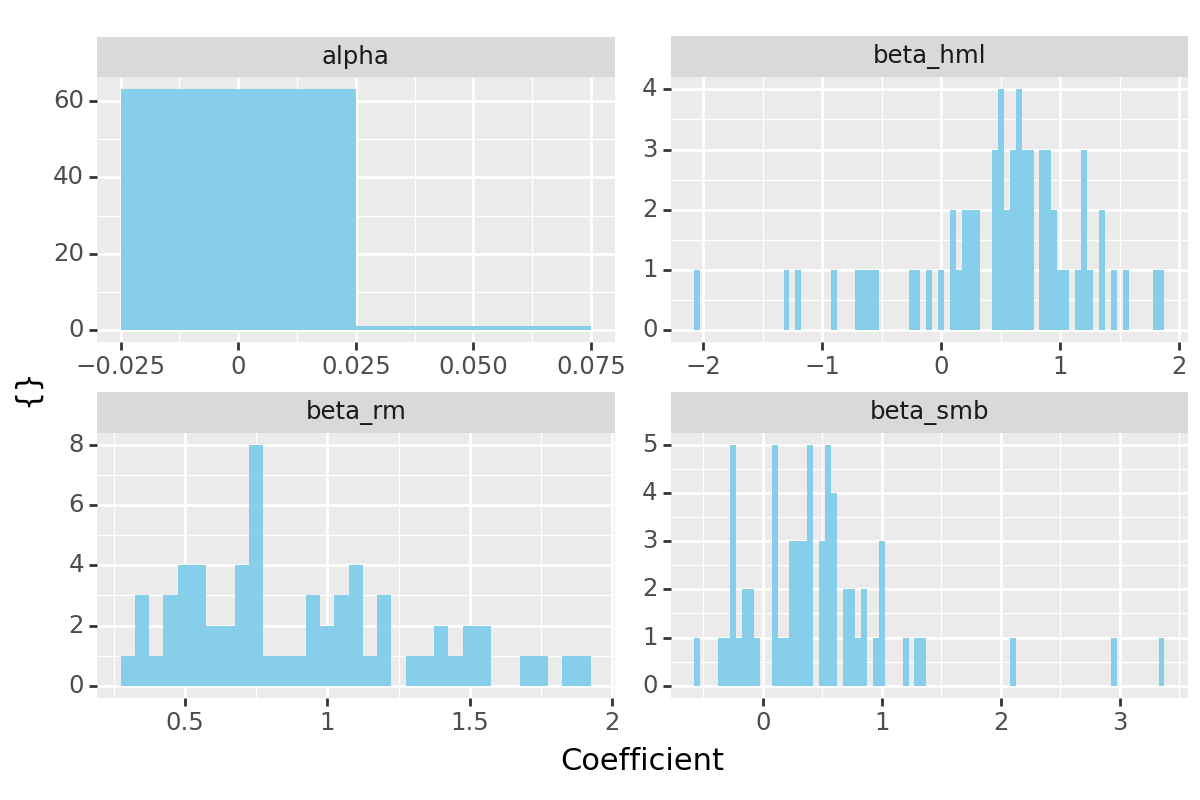

In [63]:
(
    ggplot(
        ff_reg_coef.query('coeff != "residuals"') # we don't want to plot the residuals
        ) + 
    aes(x = 'value') +
    geom_histogram(binwidth=0.05, fill='skyblue') +
    facet_wrap('coeff',scales='free') + 
    labs(x='Coefficient',y=element_blank()) +
    # theme_minimal() +
    theme(
      legend_position=(0.15,0.9),
      legend_title=element_blank(),
      legend_direction='vertical',
      figure_size=(6,4),
      )
).draw()

Notes:

Interpretation: the mean of alpha is close to 0, while the mean of all the other values are well above zero. This means that an increase to either of the $x$ variable increases so does the stock's excess return.

##### *Derive the model-implied expected gross excess return $\hat{\mu}^{FF}$ and the model-implied variance covariance matrix $\hat{\Sigma}^{FF}$. What determines the correlation of the returns?*

In [16]:
input_mean_df = df_ff.groupby('permno')[['mkt_excess','smb','hml']].mean()
df_ff_model = pd.merge(input_mean_df,ff_reg_coef_unstack,left_index=True,right_index=True,how='inner')
chatgpt = df_ff_model['alpha'] + df_ff_model['mkt_excess']*df_ff_model['beta_rm'] + df_ff_model['smb']*df_ff_model['beta_smb'] + df_ff_model['hml']*df_ff_model['beta_hml']


In [17]:
# merge the estimated coeffcients to the original dataframe
df_ff_model = df_ff.merge(ff_reg_coef_unstack,on='permno',how='left')
# model the excess return for each stock
df_ff_model['ret_excess_model'] = (df_ff_model['alpha'] + 
                                   df_ff_model['beta_rm']*df_ff_model['mkt_excess'] + 
                                   df_ff_model['beta_smb']*df_ff_model['smb'] + 
                                   df_ff_model['beta_hml']*df_ff_model['hml'])
# pivot the dataframe to have the excess return for each stock in columns
df_ff_model_pivot = df_ff_model.pivot(index='month',columns='permno',values='ret_excess_model')  


In [107]:
Sigma_f = df_ff[['mkt_excess', 'smb', 'hml']].cov().values
betas = ff_reg_coef_unstack[['beta_rm','beta_smb','beta_hml']].values
betas@Sigma_f@betas.T + np.diag(ff_reg_coef_unstack['residuals'].values)


array([[0.00645482, 0.00296748, 0.00095505, ..., 0.00228154, 0.0018611 ,
        0.00106874],
       [0.00296748, 0.02279082, 0.00253653, ..., 0.00488764, 0.00394535,
        0.00198743],
       [0.00095505, 0.00253653, 0.01339783, ..., 0.00167369, 0.00172978,
        0.00079228],
       ...,
       [0.00228154, 0.00488764, 0.00167369, ..., 0.00928652, 0.00359804,
        0.00199656],
       [0.0018611 , 0.00394535, 0.00172978, ..., 0.00359804, 0.0083303 ,
        0.00205609],
       [0.00106874, 0.00198743, 0.00079228, ..., 0.00199656, 0.00205609,
        0.01453746]])

In [ ]:
# calculate the mean and covariance matrix
mu_ff = df_ff_model_pivot.mean(axis=0).values + 1
S_ff = df_ff_model_pivot.cov().values

df_ff#.groupby('permno').apply(ff_regression)

Tried to decompose the covariance matrix into the three factors but didnt succeed. 

In [ ]:
# # initialize a dict with all inputs to ret_excess_model
# inputs = {coeff: column for coeff,column in zip(['alpha','beta_rm','beta_smb','beta_hml'],['ones','mkt_excess','smb','hml'])}
# inputs_cov = {key: np.nan for key in ['alpha','beta_rm','beta_smb','beta_hml']}
# inputs_cov = []
# df_ff_model['ones'] = 1

# for key, val in inputs.items():
#     inputs_cov.append(df_ff_model.assign(x=df_ff_model[key]*df_ff_model[val]).pivot(index='month',columns='permno',values='x').cov().values)


# df_ff_model['permno'].unique().shape[0]
# decomp_covariance = np.zeros(df_ff_model['permno'].unique().shape[0])
# for demp_cov in inputs_cov:
    


It is covariance between the inputs variables that drive the correlation of the returns. But also the covariance between the residuals.

### Question 3

Use your parameter estimates to report the computed implied mean-variance eﬀicient portfolio weight for an investor with risk aversion $\gamma=4$, defined by the solution to the problem
$$\omega^* = \arg \: \max_{\Sigma_{i=1}^N w_i=1} \omega'\hat{\mu}^{FF} - \frac{\gamma}{2} \omega' \hat{\Sigma}^{FF} \omega$$
has the analytical solution
$$\omega^* = \frac{1}{\gamma} (\Sigma^{-1}  - \frac{1}{\iota \Sigma^{-1} \iota} \Sigma^{-1}\iota \iota'\Sigma^{-1} )\mu + \frac{1}{\iota \Sigma^{-1} \iota} \Sigma^{-1}
= \frac{1}{\gamma} (\Sigma^{-1} \mu - \frac{\iota \Sigma^{-1} \mu - \gamma}{\iota \Sigma^{-1} \iota} \Sigma^{-1} \iota )$$


In [ ]:
gamma = 4
N = mu_ff.size
S_ff_inv = np.linalg.inv(S_ff)
iota = np.ones(N)


# Calculate the numerator part
B = iota @ S_ff_inv
C = B @ iota
numerator = S_ff_inv @ mu_ff - ((B @ mu_ff - gamma) / C) * (S_ff_inv @ iota)

# Calculate the optimal weights
weights_analytical = numerator / gamma
weights_analytical /= weights_analytical.sum()
weights_analytical


In [ ]:

l_lambda = (1/(iota.T @ S_ff_inv @ iota)) * (iota.T @ S_ff_inv @ mu_ff - gamma)
weights = (mu_ff - l_lambda * iota) @ S_ff_inv / gamma
weights /= weights.sum()

print(weights)

In [ ]:
obj_fun = lambda w: -((w @ mu_ff) - (gamma / 2) * w.T @ S_ff @ w )
opt_w = minimize(
    fun=obj_fun,
    x0=weights_analytical,
    constraints=({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}),
    # bounds=[(0, 1) for i in range(N)]
    options={'maxiter':1e6}
).x

In [ ]:
opt_w

In [ ]:
print(f'Objective function value is {-obj_fun(opt_w)} and for the analytical solution it is {-obj_fun(weights_analytical)}')
print(f'it is {-obj_fun(weights)}')

# Exercise 2

In [ ]:
df_pp = df.loc[df['month']<='2015-12-31']

In [ ]:
gamma = 4
N = df_pp['permno'].unique().size
naive_portfolio = 1/N * np.ones((N,df_pp['month'].unique().size))
r_it =  df_pp.pivot(index='month',columns='permno',values='ret_excess')

df_pp.assign(x=1)

def calc_pp_weight(theta): 
    df_pp.loc[:,'x'] = (df_pp[['beta','size','bm']]*theta.T).sum(axis=1)
    return df_pp.pivot(index='month',columns='permno',values='x')*1/N + 1/N

def objective_function_ex2(theta):
    w_it = calc_pp_weight(theta)
    R_pt = (w_it*r_it).sum(axis=1) + 1
    E_R = R_pt.mean()
    Var_R = R_pt.var()
    return -(E_R - (gamma/2)*Var_R)


results = minimize(
    fun=objective_function_ex2,
    x0=np.ones(3),
    options={'maxiter':1e6}
)
theta_hat = results.x 
theta_hat

In [ ]:
w_pp = calc_pp_weight(theta_hat).iloc[-1,:].values
w_pp


# Exercise 3

In [ ]:
# Estimate the covariance matrix
def cov1Para(Y,k = None):
    """
    This function estimates the covariance matrix for the stocks in the crsp_monthly dataset
    """
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
    #default setting
    if k is None:
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1
    #vars
    n = N-k                                    # adjust effective sample size
    
    
    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    # compute shrinkage target
    diag = np.diag(sample.to_numpy())
    meanvar= sum(diag)/len(diag)
    target=meanvar*np.eye(p)
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    

    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # compute shrinkage intensity
    kappahat=pihat/gammahat
    shrinkage=max(0,min(1,kappahat/n))
    
    # compute shrinkage estimator
    sigmahat=shrinkage*target+(1-shrinkage)*sample
    
    return sigmahat

In [ ]:
df_pf_train = df.loc[df['month']<='2015-12-31']
df_pf_test = df.loc[df['month']>'2015-12-31']

# check if the lengths of unqiue permnos are the same
if not df_pf_train['permno'].unique().shape[0] == df_pf_test['permno'].unique().shape[0]:
    raise ValueError('The number of unique permnos in the training and test set are not the same')

In [ ]:
df_pf_train_pivot = df_pf_train.pivot(index='month',columns='permno',values='ret_excess')
mu_tilde = df_pf_train_pivot.mean(axis=0).values
S_tilde = cov1Para(df_pf_train_pivot).values
del df_pf_train_pivot

In [ ]:
def calculate_min_variance_portfolio(Sigma):
    """
    This function calculates the minimum variance portfolio
    """
    Sigma_inv = np.linalg.inv(Sigma)
    w_mvp = Sigma_inv @ iota    
    w_mvp = w_mvp/np.sum(w_mvp) # normalize weights
    return w_mvp
def calculate_efficient_portfolio(Sigma, mu, gamma, return_multiple = 2):
    """
    This function calculates the efficient portfolio
    """
    Sigma_inv = np.linalg.inv(Sigma)
    #----- minimum variance portfolio    
    mvp_weights = calculate_min_variance_portfolio(Sigma)

    #----- efficient frontier portfolio
    mu_bar = return_multiple * mvp_weights.T @ mu
    C = iota.T @ Sigma_inv @ iota
    D = iota.T @ Sigma_inv @ mu
    E = mu.T @ Sigma_inv @ mu
    lambda_tilde = 2 * (mu_bar - D/C) / (E-D**2/C)
    efp_weights = mvp_weights + lambda_tilde/2 * (Sigma_inv@mu - D* mvp_weights ) 
    return efp_weights

def calculate_naive_portfolio(N):
    """
    This function calculates the naive portfolio
    """
    return 1/N * np.ones(N)

naive_portfolio = calculate_naive_portfolio(mu_tilde.shape[0])
eff_portfolio = calculate_efficient_portfolio(S_tilde, mu_tilde, gamma)


In [ ]:
mmr_ni = ((df_pf_test.pivot(index='month',columns='permno',values='ret_excess').values) @ naive_portfolio).mean()
mmr_eff = ((df_pf_test.pivot(index='month',columns='permno',values='ret_excess').values) @ eff_portfolio).mean()
mmr_opt = ((df_pf_test.pivot(index='month',columns='permno',values='ret_excess').values) @ opt_w).mean()
mmr_pp = ((df_pf_test.pivot(index='month',columns='permno',values='ret_excess').values) @ w_pp).mean()


In [ ]:
print(f'The mean monthly return for the naive portfolio is {mmr_ni:.3%}')
print(f'The mean monthly return for the efficient portfolio is {mmr_eff:.3%}')
print(f'The mean monthly return for the efficient portfolio is {mmr_pp:.3%}')

In [ ]:
cov_ni = (naive_portfolio @ df_pf_test.pivot(index='month',columns='permno',values='ret_excess').cov() @ naive_portfolio)
cov_eff = (eff_portfolio @ df_pf_test.pivot(index='month',columns='permno',values='ret_excess').cov() @ eff_portfolio)
cov_opt = (opt_w @ df_pf_test.pivot(index='month',columns='permno',values='ret_excess').cov() @ opt_w)
cov_pp = (w_pp @ df_pf_test.pivot(index='month',columns='permno',values='ret_excess').cov() @ w_pp)


In [ ]:
print(f'The variance of the naive portfolio is {cov_ni:.3%}')
print(f'The variance of the efficient portfolio is {cov_eff:.3%}')
print(f'The variance of the optimal portfolio is {cov_opt:.3%}')
print(f'The variance of the paper portfolio is {cov_pp:.3%}')

In [ ]:
def sharpe_ratio(ret,var,fac=12):
    """
    """
    mmr = ret * fac
    std = np.sqrt(var) * np.sqrt(fac)
    return mmr/std

df_rep = pd.DataFrame({
    'Naive': [mmr_ni,cov_ni,sharpe_ratio(mmr_ni,cov_ni)],
    'Efficient': [mmr_eff,cov_eff,sharpe_ratio(mmr_eff,cov_eff)],
    'Ex1': [mmr_opt,cov_opt,sharpe_ratio(mmr_opt,cov_opt)],
    'Ex2': [mmr_pp,cov_pp,sharpe_ratio(mmr_pp,cov_pp)]
},index=['Mean','Variance','Sharpe Ratio']).T

df_rep.style.format({
    'Mean': '{:.2%}',
    'Variance': '{:.2%}',
    'Sharpe Ratio': '{:.2f}'
})

In [ ]:
df_rep_weights = pd.DataFrame({
    'Naive': naive_portfolio,
    'Efficient': eff_portfolio,
    # 'Ex1': opt_w
}#,index=df_pf_test['permno'].unique()
).stack().reset_index().rename(columns={'level_0':'permno','level_1':'Portfolio',0:'Weight'})
print(df_rep_weights )

In [ ]:
(
    ggplot(df_rep_weights, aes(x='permno', y='Weight')) + 
    geom_bar(stat='identity', fill='skyblue') + 
    facet_wrap('Portfolio',scales='free') +
    labs(x='Ticker', y='Weight') +
    scale_y_continuous(labels=percent_format()) +
                      #  )  +
    # theme_minimal() + 
    theme(
          axis_text_x=element_blank(),
          axis_ticks_major_x=element_blank(),
          # axis_text_x=element_text(angle=90, vjust=0.5, hjust=0.5),
          figure_size=(6,4), )
        )